# PCA Signal Reconstruction Viewer

This notebook allows you to visualize the original weather signal and its reconstruction using PCA components and coefficients.

**Features:**
- Load PCA components and coefficients
- Select a specific row/station to analyze
- View progressive reconstruction: mean, mean+PC1, mean+PC1+PC2, etc.
- Interactive visualization with matplotlib


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up paths
pca_results_dir = "../weather_info/pca_results/"
coefficients_file = "../../../weather_data/per_row_coefficients.parquet"

print(f"PCA results directory: {pca_results_dir}")
print(f"Coefficients file: {coefficients_file}")
print(f"Files exist: PCA dir={os.path.exists(pca_results_dir)}, Coefficients={os.path.exists(coefficients_file)}")


PCA results directory: ../weather_info/pca_results/
Coefficients file: ../../../weather_data/per_row_coefficients.parquet
Files exist: PCA dir=True, Coefficients=True


In [2]:
# Load PCA results for all measurement types
def load_pca_results(pca_dir):
    """Load all PCA results from pickle files."""
    measurement_types = ['snwd', 'prcp', 'tmin', 'snow', 'tmax', 'tobs', 'tavg']
    pca_results = {}
    
    for measurement in measurement_types:
        pca_file = os.path.join(pca_dir, f"{measurement}_pca_results.pkl")
        
        if os.path.exists(pca_file):
            try:
                with open(pca_file, 'rb') as f:
                    results = pickle.load(f)
                    pca_results[measurement.upper()] = results
                    print(f"Loaded PCA results for {measurement.upper()}: "
                          f"components {results['components'].shape}, "
                          f"mean {results['mean'].shape}")
            except Exception as e:
                print(f"Error loading {pca_file}: {e}")
        else:
            print(f"PCA file not found: {pca_file}")
    
    return pca_results

# Load PCA results
pca_results = load_pca_results(pca_results_dir)
print(f"\nLoaded PCA results for {len(pca_results)} measurement types: {list(pca_results.keys())}")


Loaded PCA results for SNWD: components (10, 365), mean (365,)
Loaded PCA results for PRCP: components (10, 365), mean (365,)
Loaded PCA results for TMIN: components (10, 365), mean (365,)
Loaded PCA results for SNOW: components (10, 365), mean (365,)
Loaded PCA results for TMAX: components (10, 365), mean (365,)
Loaded PCA results for TOBS: components (10, 365), mean (365,)
Loaded PCA results for TAVG: components (10, 365), mean (365,)

Loaded PCA results for 7 measurement types: ['SNWD', 'PRCP', 'TMIN', 'SNOW', 'TMAX', 'TOBS', 'TAVG']


In [3]:
# Load coefficients data
print("Loading coefficients data...")
coefficients_df = pd.read_parquet(coefficients_file)
print(f"Coefficients data shape: {coefficients_df.shape}")
print(f"Columns: {coefficients_df.columns.tolist()}")
print(f"\nSample data:")
print(coefficients_df.head())

# Check available measurement types in coefficients
available_elements = coefficients_df['ELEMENT'].unique()
print(f"\nAvailable measurement types: {available_elements}")


Loading coefficients data...


Coefficients data shape: (7415065, 389)
Columns: ['station_id_x', 'latitude', 'longitude', 'elevation', 'state', 'name', 'gsn_flag', 'hcn_crn_flag', 'wmo_id', 'ID', 'year', 'ELEMENT', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'day_32', 'day_33', 'day_34', 'day_35', 'day_36', 'day_37', 'day_38', 'day_39', 'day_40', 'day_41', 'day_42', 'day_43', 'day_44', 'day_45', 'day_46', 'day_47', 'day_48', 'day_49', 'day_50', 'day_51', 'day_52', 'day_53', 'day_54', 'day_55', 'day_56', 'day_57', 'day_58', 'day_59', 'day_60', 'day_61', 'day_62', 'day_63', 'day_64', 'day_65', 'day_66', 'day_67', 'day_68', 'day_69', 'day_70', 'day_71', 'day_72', 'day_73', 'day_74', 'day_75', 'day_76', 'day_77', 'day_78', 'day_79', 'day_80', 'day_81', 'day_82', 'day_

In [4]:
# Function to reconstruct signal using PCA components and coefficients
def reconstruct_signal(mean_values, components, coefficients, n_components=None):
    """
    Reconstruct signal using PCA components and coefficients.
    
    Args:
        mean_values: Mean values for centering (365,)
        components: PCA components (n_components, 365)
        coefficients: PCA coefficients for this row (n_components,)
        n_components: Number of components to use (None = all)
    
    Returns:
        Reconstructed signal (365,)
    """
    if n_components is None:
        n_components = len(coefficients)
    
    # Start with mean
    reconstructed = mean_values.copy()
    
    # Add contributions from each component
    for i in range(min(n_components, len(coefficients))):
        reconstructed += coefficients[i] * components[i]
    
    return reconstructed

# Function to get progressive reconstructions
def get_progressive_reconstructions(mean_values, components, coefficients):
    """
    Get reconstructions using 0, 1, 2, ..., n components.
    
    Returns:
        List of reconstructed signals
    """
    reconstructions = []
    
    # Start with just the mean
    reconstructions.append(mean_values.copy())
    
    # Add components progressively
    for i in range(len(coefficients)):
        reconstructed = reconstruct_signal(mean_values, components, coefficients, i+1)
        reconstructions.append(reconstructed)
    
    return reconstructions

print("Reconstruction functions defined successfully!")


Reconstruction functions defined successfully!


In [5]:
# Interactive function to visualize reconstruction for a specific row
def visualize_reconstruction(row_idx, measurement_type, show_progressive=True, max_components=3, show_original=True):
    """
    Visualize reconstruction for a specific row.
    
    Args:
        row_idx: Index of the row to visualize
        measurement_type: Type of measurement (e.g., 'TOBS')
        show_progressive: Whether to show progressive reconstructions
        max_components: Maximum number of components to show (default: 3)
        show_original: Whether to show the original signal
    """
    # Get the specific row
    row_data = coefficients_df.iloc[row_idx]
    
    # Verify measurement type matches
    if row_data['ELEMENT'] != measurement_type:
        print(f"Warning: Row {row_idx} has element {row_data['ELEMENT']}, not {measurement_type}")
        return
    
    # Get PCA results for this measurement type
    if measurement_type not in pca_results:
        print(f"No PCA results found for {measurement_type}")
        return
    
    pca_data = pca_results[measurement_type]
    mean_values = pca_data['mean']
    components = pca_data['components']
    
    # Get coefficients for this row
    coefficients = [row_data[f'PC{i+1}'] for i in range(10)]
    
    # Get original signal (reconstructed with all components)
    original_signal = reconstruct_signal(mean_values, components, coefficients)
    
    # Get reconstruction with only top 3 components
    reconstruction_3pc = reconstruct_signal(mean_values, components, coefficients, n_components=3)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Days of year for x-axis
    days = np.arange(1, 366)
    
    if show_progressive:
        # Show progressive reconstructions
        reconstructions = get_progressive_reconstructions(mean_values, components, coefficients)
        
        # Plot mean only
        ax.plot(days, reconstructions[0], 'k--', alpha=0.7, linewidth=2, label='Mean only')
        
        # Plot progressive reconstructions (up to max_components)
        colors = plt.cm.viridis(np.linspace(0, 1, min(max_components, len(reconstructions)-1)))
        for i in range(1, min(max_components+1, len(reconstructions))):
            ax.plot(days, reconstructions[i], color=colors[i-1], alpha=0.8, 
                   label=f'Mean + PC1-{i}')
        
        # Plot reconstruction with top 3 components
        ax.plot(days, reconstruction_3pc, 'b-', linewidth=3, label=f'Reconstruction (Top {max_components} PCs)')
        
        # Always plot original signal
        ax.plot(days, original_signal, 'r-', linewidth=2, alpha=0.8, label='Original Signal (All PCs)')
        
    else:
        # Just show mean, reconstruction with top 3, and original
        ax.plot(days, mean_values, 'k--', alpha=0.7, linewidth=2, label='Mean')
        ax.plot(days, reconstruction_3pc, 'b-', linewidth=3, label=f'Reconstruction (Top {max_components} PCs)')
        # Always plot original signal
        ax.plot(days, original_signal, 'r-', linewidth=2, alpha=0.8, label='Original Signal (All PCs)')
    
    # Formatting
    ax.set_xlabel('Day of Year')
    ax.set_ylabel(f'{measurement_type} Value')
    ax.set_title(f'{measurement_type} Signal Reconstruction\n'
                f'Row {row_idx} (Station: {row_data.get("ID", "Unknown")}, '
                f'Year: {row_data.get("year", "Unknown")})')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Add month labels
    month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
    ax.set_xticks(month_boundaries)
    ax.set_xticklabels(month_labels)
    ax.set_xlim(1, 365)
    
    plt.tight_layout()
    plt.show()
    
    # Print coefficient information
    print(f"\nPCA Coefficients for Row {row_idx}:")
    for i, coeff in enumerate(coefficients):
        print(f"  PC{i+1}: {coeff:.4f}")
    
    # Print explained variance information
    explained_variances = pca_data['explained_variances']
    explained_variance_ratios = pca_data['explained_variance_ratios']
    print(f"\nExplained Variance Ratios:")
    for i in range(min(10, len(explained_variance_ratios))):
        print(f"  PC{i+1}: {explained_variance_ratios[i]:.4f} ({explained_variance_ratios[i]*100:.2f}%)")
    
    # Calculate reconstruction error with top 3 components
    reconstruction_error = np.mean((original_signal - reconstruction_3pc) ** 2)
    print(f"\nReconstruction Error (Top 3 PCs): {reconstruction_error:.6f}")
    print(f"Explained Variance (Top 3 PCs): {explained_variance_ratios[:3].sum():.4f} ({explained_variance_ratios[:3].sum()*100:.2f}%)")
    
    # Calculate how close the original signal is to the mean
    mean_distance = np.mean((original_signal - mean_values) ** 2)
    print(f"Distance from Mean: {mean_distance:.6f}")

print("Visualization function defined successfully!")


Visualization function defined successfully!


In [6]:
# Function to find signals close to the mean
def find_signals_close_to_mean(measurement_type, n_samples=5, years_range=(2000, 2025)):
    """
    Find signals that are close to the mean signal.
    
    Args:
        measurement_type: Type of measurement (e.g., 'TOBS')
        n_samples: Number of signals to return
        years_range: Tuple of (start_year, end_year) to filter by
        
    Returns:
        List of row indices sorted by distance from mean (closest first)
    """
    if measurement_type not in pca_results:
        print(f"No PCA results found for {measurement_type}")
        return []
    
    # Filter data for the measurement type and years
    filtered_df = coefficients_df[coefficients_df['ELEMENT'] == measurement_type]
    filtered_df = filtered_df[(filtered_df['year'] >= years_range[0]) & 
                              (filtered_df['year'] <= years_range[1])]
    
    if len(filtered_df) == 0:
        print(f"No data found for {measurement_type} in years {years_range[0]}-{years_range[1]}")
        return []
    
    # Get PCA data
    pca_data = pca_results[measurement_type]
    mean_values = pca_data['mean']
    components = pca_data['components']
    
    # Calculate distance from mean for each row
    distances = []
    for idx in filtered_df.index:
        row_data = filtered_df.loc[idx]
        coefficients = [row_data[f'PC{i+1}'] for i in range(10)]
        original_signal = reconstruct_signal(mean_values, components, coefficients)
        distance = np.mean((original_signal - mean_values) ** 2)
        distances.append((idx, distance))
    
    # Sort by distance (closest first)
    distances.sort(key=lambda x: x[1])
    
    # Return the closest n_samples
    closest_indices = [idx for idx, _ in distances[:n_samples]]
    
    print(f"Found {len(closest_indices)} signals close to mean for {measurement_type}:")
    for i, (idx, distance) in enumerate(distances[:n_samples]):
        row_data = filtered_df.loc[idx]
        print(f"  {i+1}. Row {idx}: Station {row_data.get('ID', 'Unknown')}, "
              f"Year {row_data.get('year', 'Unknown')}, Distance: {distance:.6f}")
    
    return closest_indices

print("Signal finding function defined successfully!")


Signal finding function defined successfully!


## Interactive Visualization

Now you can visualize signal reconstructions! Here are some examples:


=== Finding TOBS Signals Close to Mean ===


Found 3 signals close to mean for TOBS:
  1. Row 6980906: Station USC00280907, Year 2012, Distance: 32.914393
  2. Row 6929368: Station USC00289363, Year 2012, Distance: 43.566469
  3. Row 6897261: Station USC00283029, Year 2012, Distance: 45.596326

Visualizing the signal closest to mean:


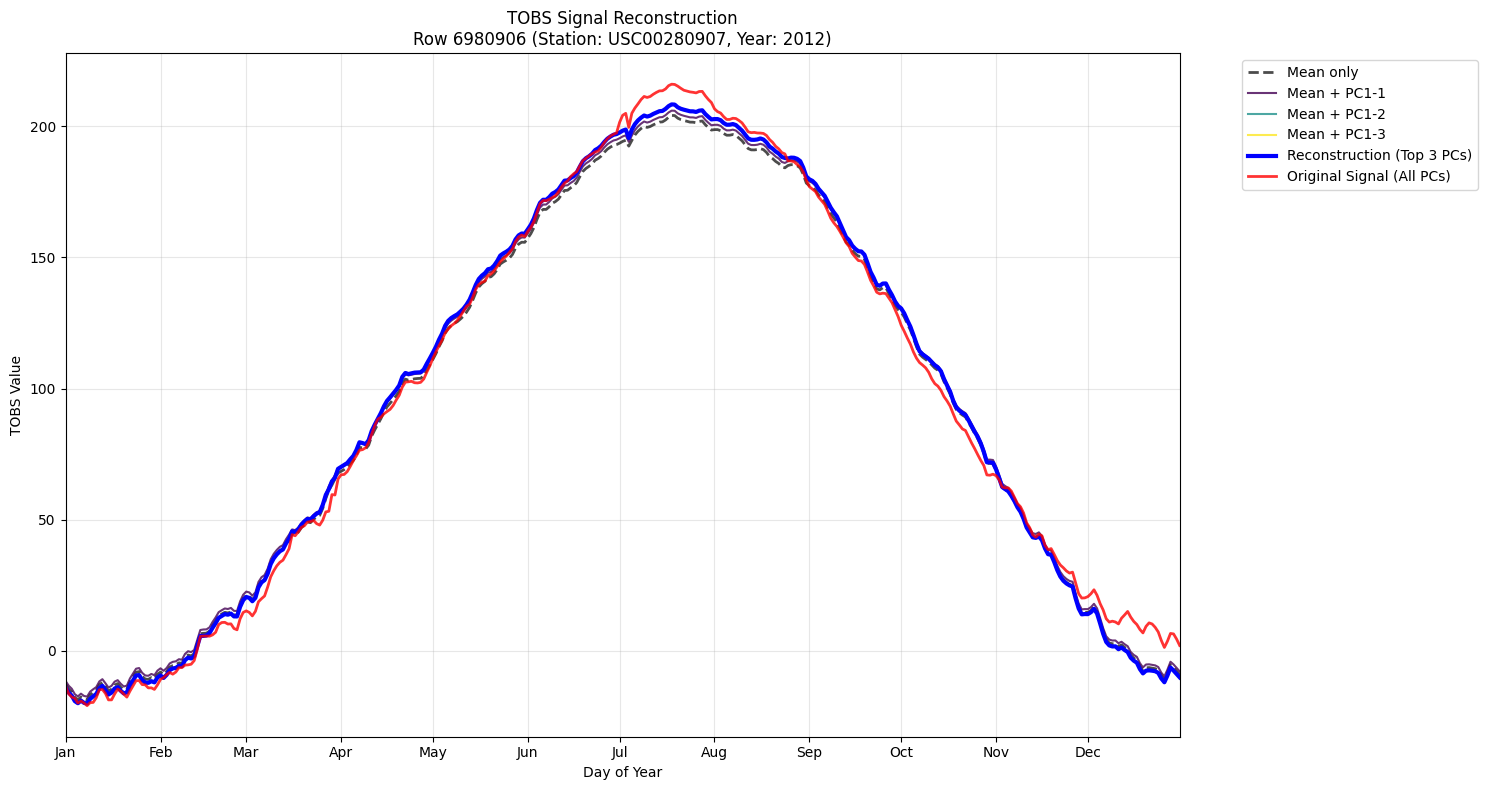


PCA Coefficients for Row 6980906:
  PC1: 30.9531
  PC2: -33.0490
  PC3: -0.6332
  PC4: 7.2777
  PC5: 92.4836
  PC6: 15.2493
  PC7: 2.9352
  PC8: 29.4916
  PC9: 12.5783
  PC10: 9.3656

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 27.295942
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 32.914393

Visualizing the second closest signal to mean:


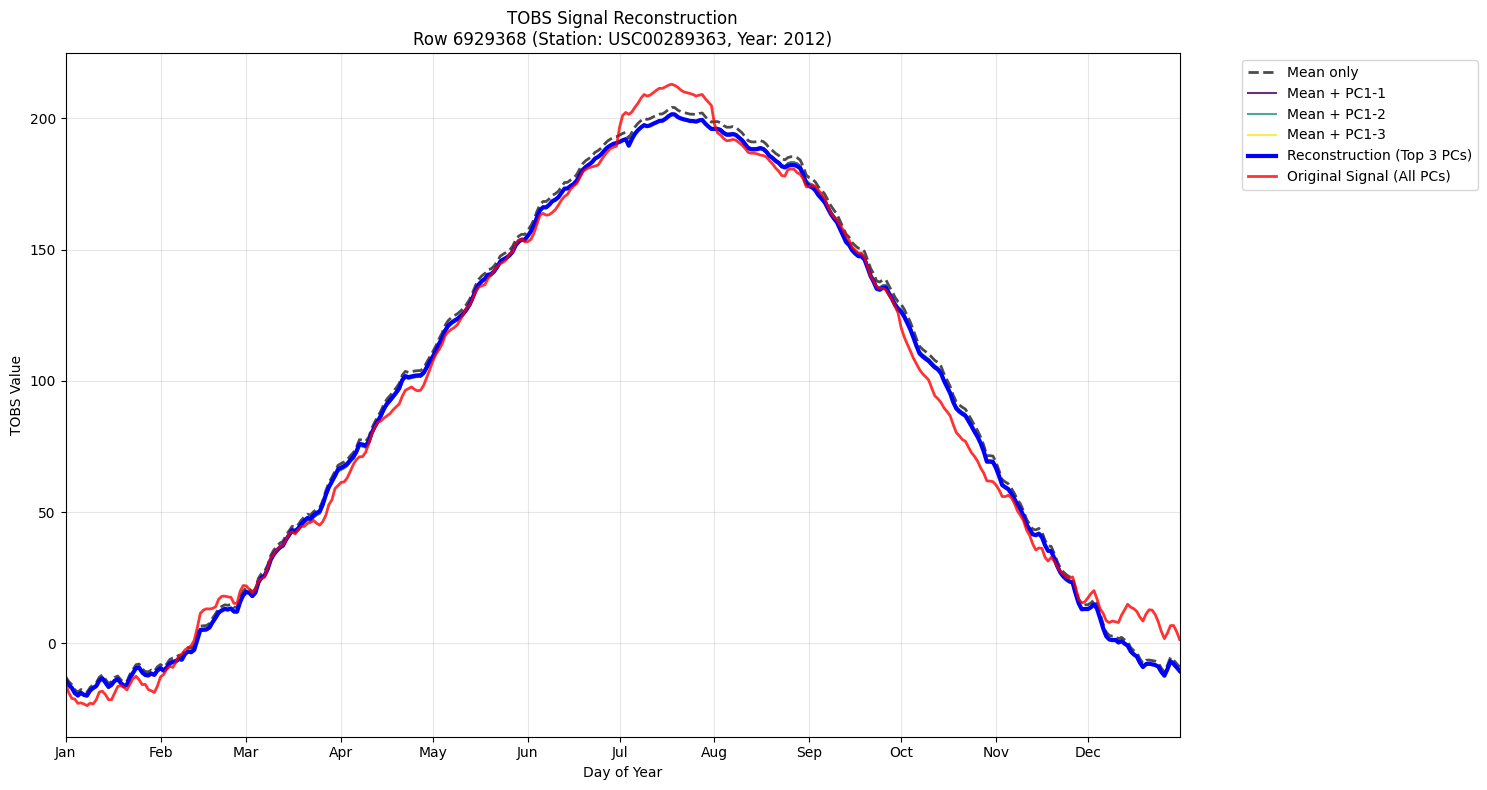


PCA Coefficients for Row 6929368:
  PC1: -40.0419
  PC2: 3.1034
  PC3: -9.3013
  PC4: -9.5361
  PC5: 77.2772
  PC6: -4.6550
  PC7: -20.3350
  PC8: 73.7759
  PC9: 33.4252
  PC10: 33.8270

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 38.910316
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 43.566469


In [7]:
# Example: Find signals close to the mean and visualize the closest one
if 'TOBS' in pca_results:
    print("=== Finding TOBS Signals Close to Mean ===")
    
    # Find signals close to the mean
    closest_indices = find_signals_close_to_mean('TOBS', n_samples=3, years_range=(2000, 2025))
    
    if len(closest_indices) > 0:
        # Visualize the closest signal to the mean
        closest_idx = closest_indices[0]
        print(f"\nVisualizing the signal closest to mean:")
        visualize_reconstruction(closest_idx, 'TOBS', show_progressive=True, max_components=3)
        
        # Also visualize the second closest
        if len(closest_indices) > 1:
            print(f"\nVisualizing the second closest signal to mean:")
            visualize_reconstruction(closest_indices[1], 'TOBS', show_progressive=True, max_components=3)
    else:
        print("No TOBS signals found close to mean")
else:
    print("TOBS PCA results not available")


=== Comparing Signals Close to Mean vs Far from Mean ===


Found 2 signals close to mean for TOBS:
  1. Row 6980906: Station USC00280907, Year 2012, Distance: 32.914393
  2. Row 6929368: Station USC00289363, Year 2012, Distance: 43.566469



Signals far from mean (highest coefficient magnitudes):
  1. Row 6791505: Station USS0064P01S, Year 2015, Magnitude: 25085.3070
  2. Row 6719843: Station USS0051K15S, Year 2015, Magnitude: 21572.5070

=== Signal Close to Mean ===


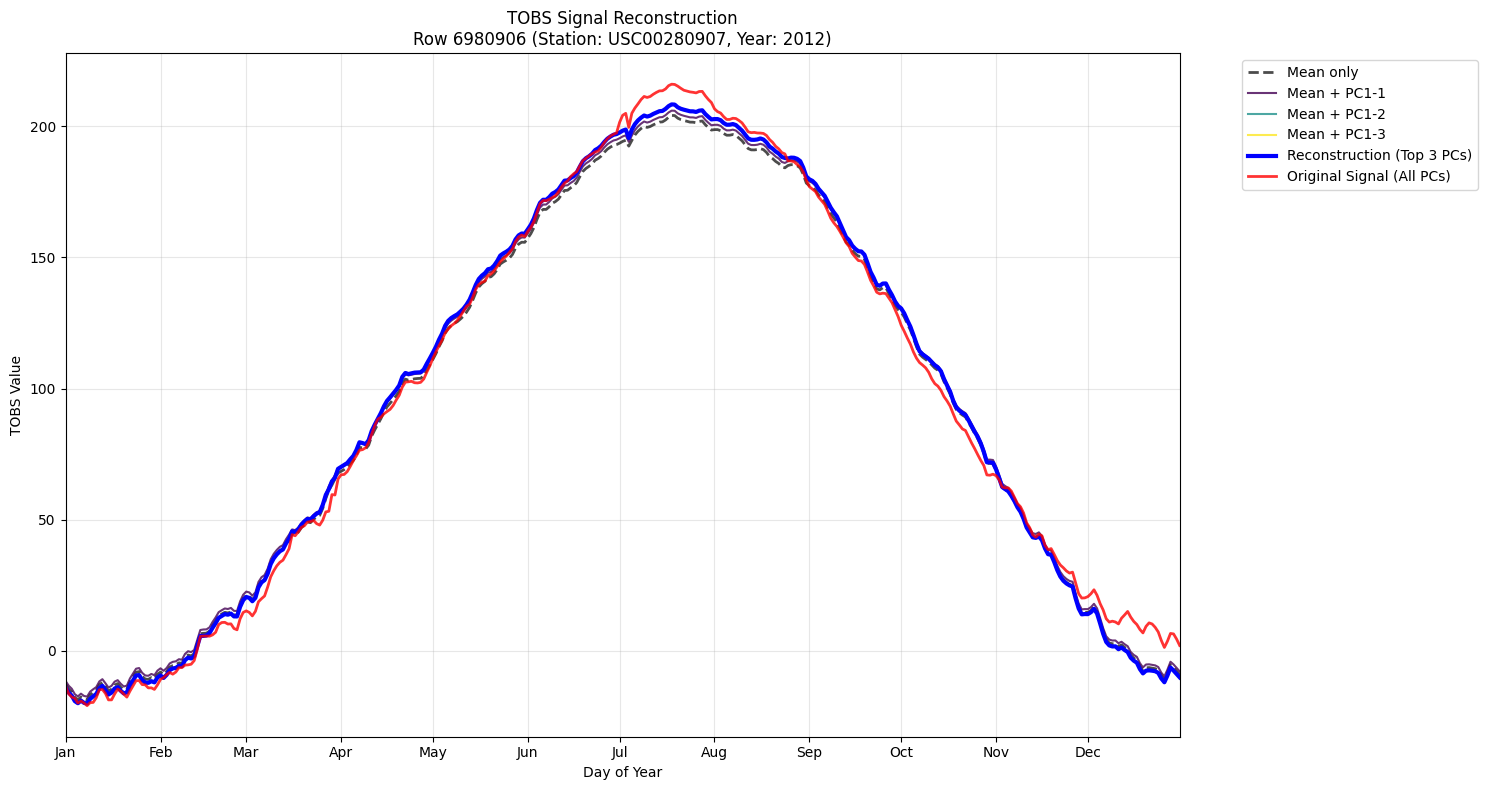


PCA Coefficients for Row 6980906:
  PC1: 30.9531
  PC2: -33.0490
  PC3: -0.6332
  PC4: 7.2777
  PC5: 92.4836
  PC6: 15.2493
  PC7: 2.9352
  PC8: 29.4916
  PC9: 12.5783
  PC10: 9.3656

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 27.295942
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 32.914393

=== Signal Far from Mean ===


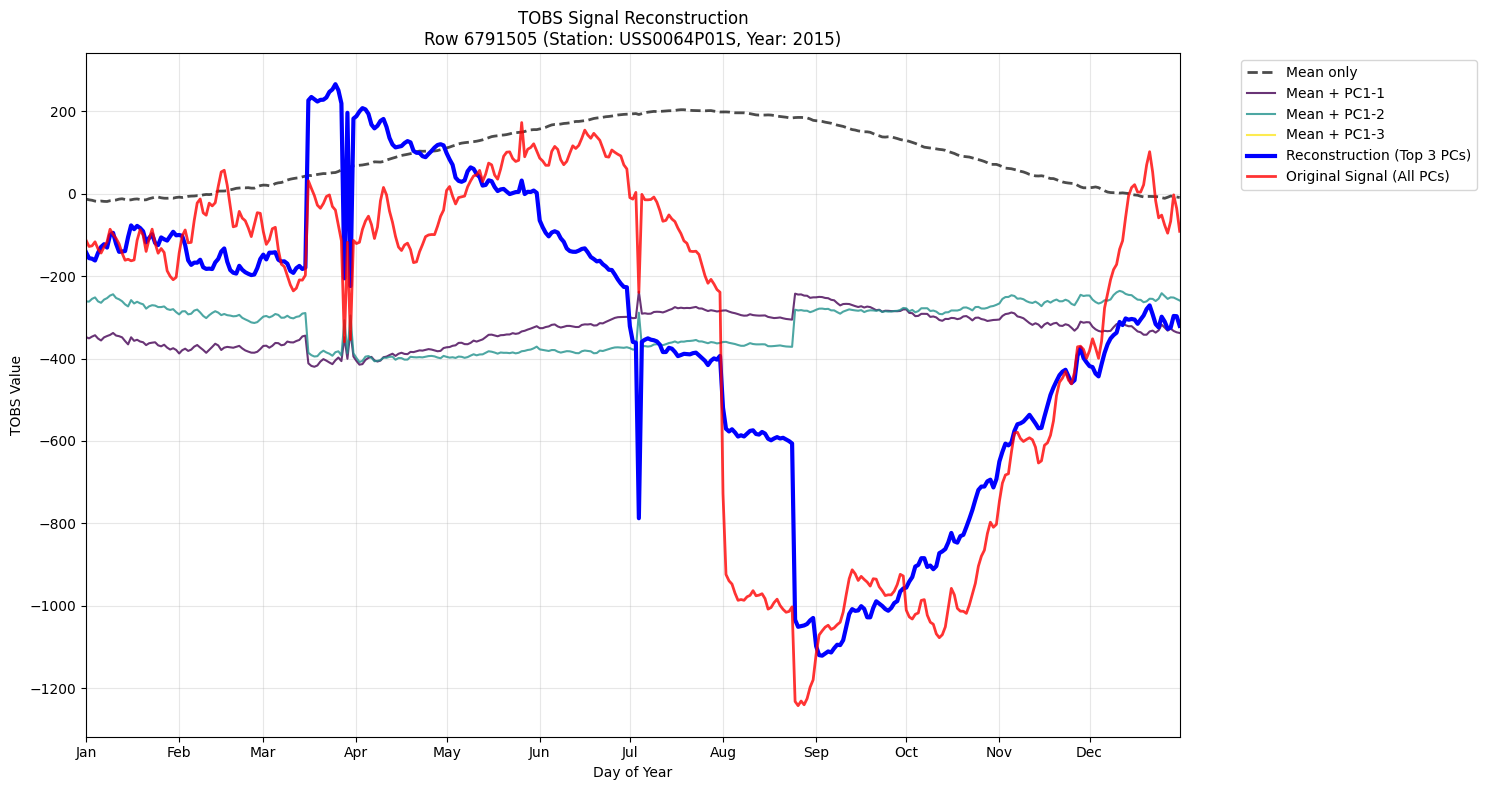


PCA Coefficients for Row 6791505:
  PC1: -8156.4417
  PC2: 1141.6587
  PC3: -7555.5099
  PC4: 292.0969
  PC5: 1761.3068
  PC6: -2816.6144
  PC7: -171.0463
  PC8: 1436.9538
  PC9: 1020.3262
  PC10: 733.3523

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 40530.966985
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 382768.381528


In [8]:
# Example: Compare signals close to mean vs far from mean
if 'TOBS' in pca_results:
    print("=== Comparing Signals Close to Mean vs Far from Mean ===")
    
    # Find signals close to the mean
    closest_indices = find_signals_close_to_mean('TOBS', n_samples=2, years_range=(2000, 2025))
    
    # Find signals far from the mean (highest coefficient magnitudes)
    filtered_df = coefficients_df[coefficients_df['ELEMENT'] == 'TOBS']
    filtered_df = filtered_df[(filtered_df['year'] >= 2000) & (filtered_df['year'] <= 2025)]
    
    if len(filtered_df) > 0:
        # Calculate coefficient magnitudes
        pc_cols = [f'PC{i+1}' for i in range(10)]
        coefficient_magnitudes = filtered_df[pc_cols].abs().sum(axis=1)
        farthest_indices = coefficient_magnitudes.nlargest(2).index.tolist()
        
        print(f"\nSignals far from mean (highest coefficient magnitudes):")
        for i, idx in enumerate(farthest_indices):
            row_data = filtered_df.loc[idx]
            magnitude = coefficient_magnitudes[idx]
            print(f"  {i+1}. Row {idx}: Station {row_data.get('ID', 'Unknown')}, "
                  f"Year {row_data.get('year', 'Unknown')}, Magnitude: {magnitude:.4f}")
        
        # Visualize comparison
        if len(closest_indices) > 0 and len(farthest_indices) > 0:
            print(f"\n=== Signal Close to Mean ===")
            visualize_reconstruction(closest_indices[0], 'TOBS', show_progressive=True, max_components=3)
            
            print(f"\n=== Signal Far from Mean ===")
            visualize_reconstruction(farthest_indices[0], 'TOBS', show_progressive=True, max_components=3)
    else:
        print("No TOBS data found for comparison")
else:
    print("TOBS PCA results not available")


=== Finding TOBS Signals Close to Mean ===


Found 3 signals close to mean for TOBS:
  1. Row 6980906: Station USC00280907, Year 2012, Distance: 32.914393
  2. Row 6929368: Station USC00289363, Year 2012, Distance: 43.566469
  3. Row 6897261: Station USC00283029, Year 2012, Distance: 45.596326

Visualizing the signal closest to mean:


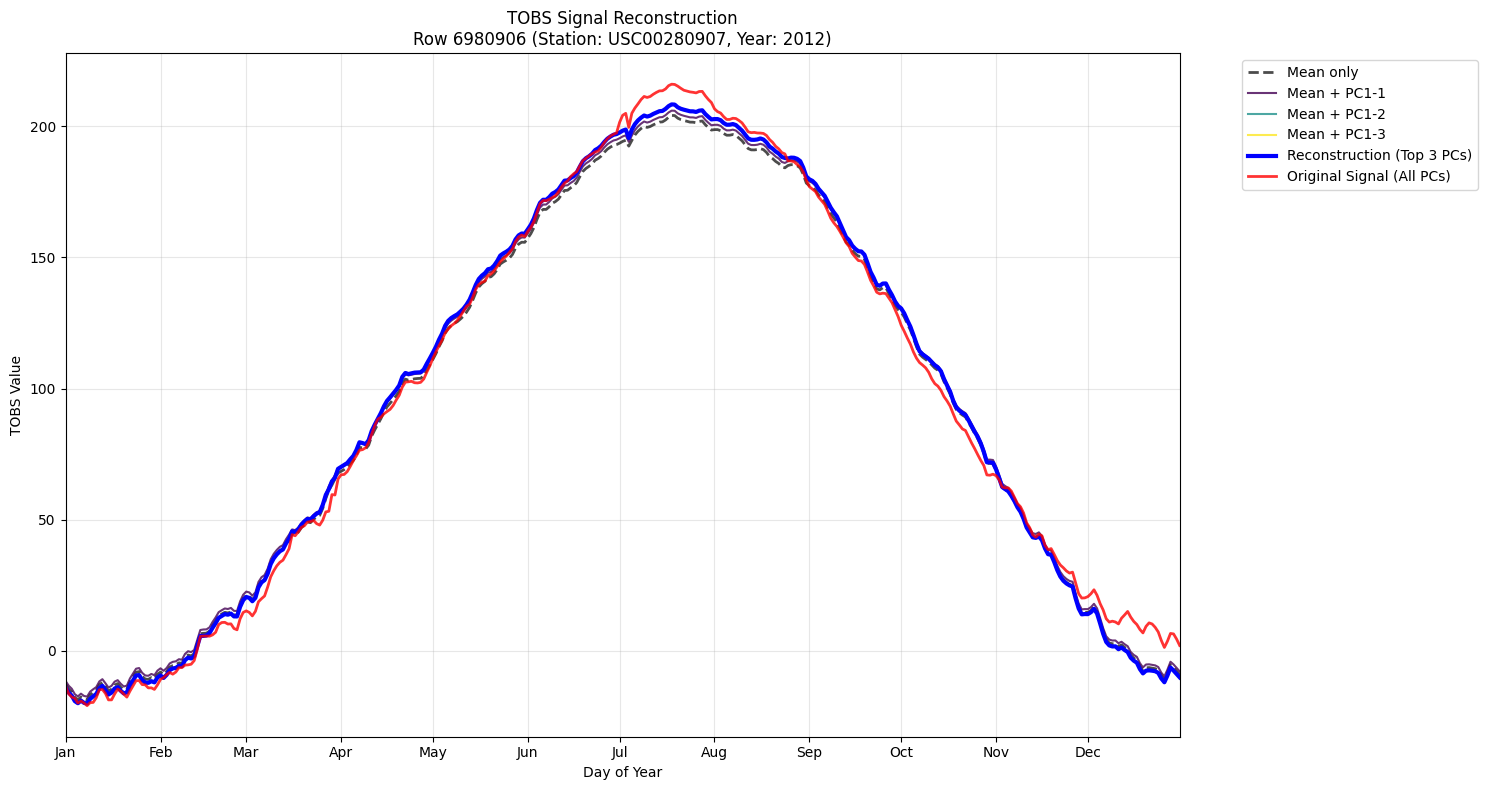


PCA Coefficients for Row 6980906:
  PC1: 30.9531
  PC2: -33.0490
  PC3: -0.6332
  PC4: 7.2777
  PC5: 92.4836
  PC6: 15.2493
  PC7: 2.9352
  PC8: 29.4916
  PC9: 12.5783
  PC10: 9.3656

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 27.295942
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 32.914393

Visualizing the second closest signal to mean:


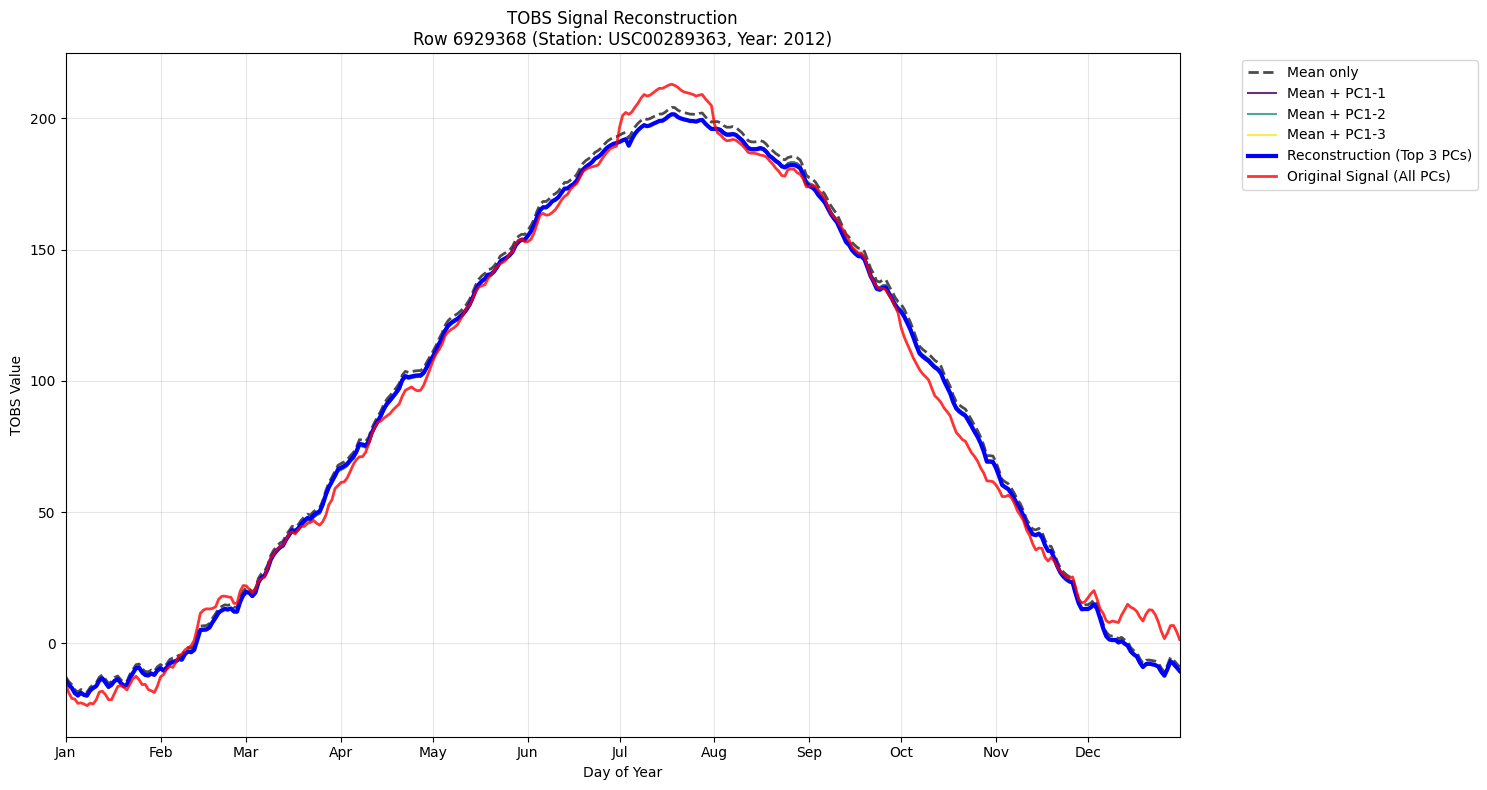


PCA Coefficients for Row 6929368:
  PC1: -40.0419
  PC2: 3.1034
  PC3: -9.3013
  PC4: -9.5361
  PC5: 77.2772
  PC6: -4.6550
  PC7: -20.3350
  PC8: 73.7759
  PC9: 33.4252
  PC10: 33.8270

Explained Variance Ratios:
  PC1: 0.7029 (70.29%)
  PC2: 0.1585 (15.85%)
  PC3: 0.0477 (4.77%)
  PC4: 0.0208 (2.08%)
  PC5: 0.0166 (1.66%)
  PC6: 0.0139 (1.39%)
  PC7: 0.0112 (1.12%)
  PC8: 0.0099 (0.99%)
  PC9: 0.0095 (0.95%)
  PC10: 0.0090 (0.90%)

Reconstruction Error (Top 3 PCs): 38.910316
Explained Variance (Top 3 PCs): 0.9091 (90.91%)
Distance from Mean: 43.566469


In [9]:
# Example: Find signals close to the mean and visualize the closest one
if 'TOBS' in pca_results:
    print("=== Finding TOBS Signals Close to Mean ===")
    
    # Find signals close to the mean
    closest_indices = find_signals_close_to_mean('TOBS', n_samples=3, years_range=(2000, 2025))
    
    if len(closest_indices) > 0:
        # Visualize the closest signal to the mean
        closest_idx = closest_indices[0]
        print(f"\nVisualizing the signal closest to mean:")
        visualize_reconstruction(closest_idx, 'TOBS', show_progressive=True, max_components=3)
        
        # Also visualize the second closest
        if len(closest_indices) > 1:
            print(f"\nVisualizing the second closest signal to mean:")
            visualize_reconstruction(closest_indices[1], 'TOBS', show_progressive=True, max_components=3)
    else:
        print("No TOBS signals found close to mean")
else:
    print("TOBS PCA results not available")


In [10]:
# Example 2: Visualize a specific row (you can change the row index)
measurement_type = 'TOBS'  # Change this to any available measurement type
row_index = 2000  # Change this to any valid row index

print(f"=== Visualizing Row {row_index} for {measurement_type} ===")
visualize_reconstruction(row_index, measurement_type, show_progressive=True, max_components=10)


=== Visualizing Row 2000 for TOBS ===


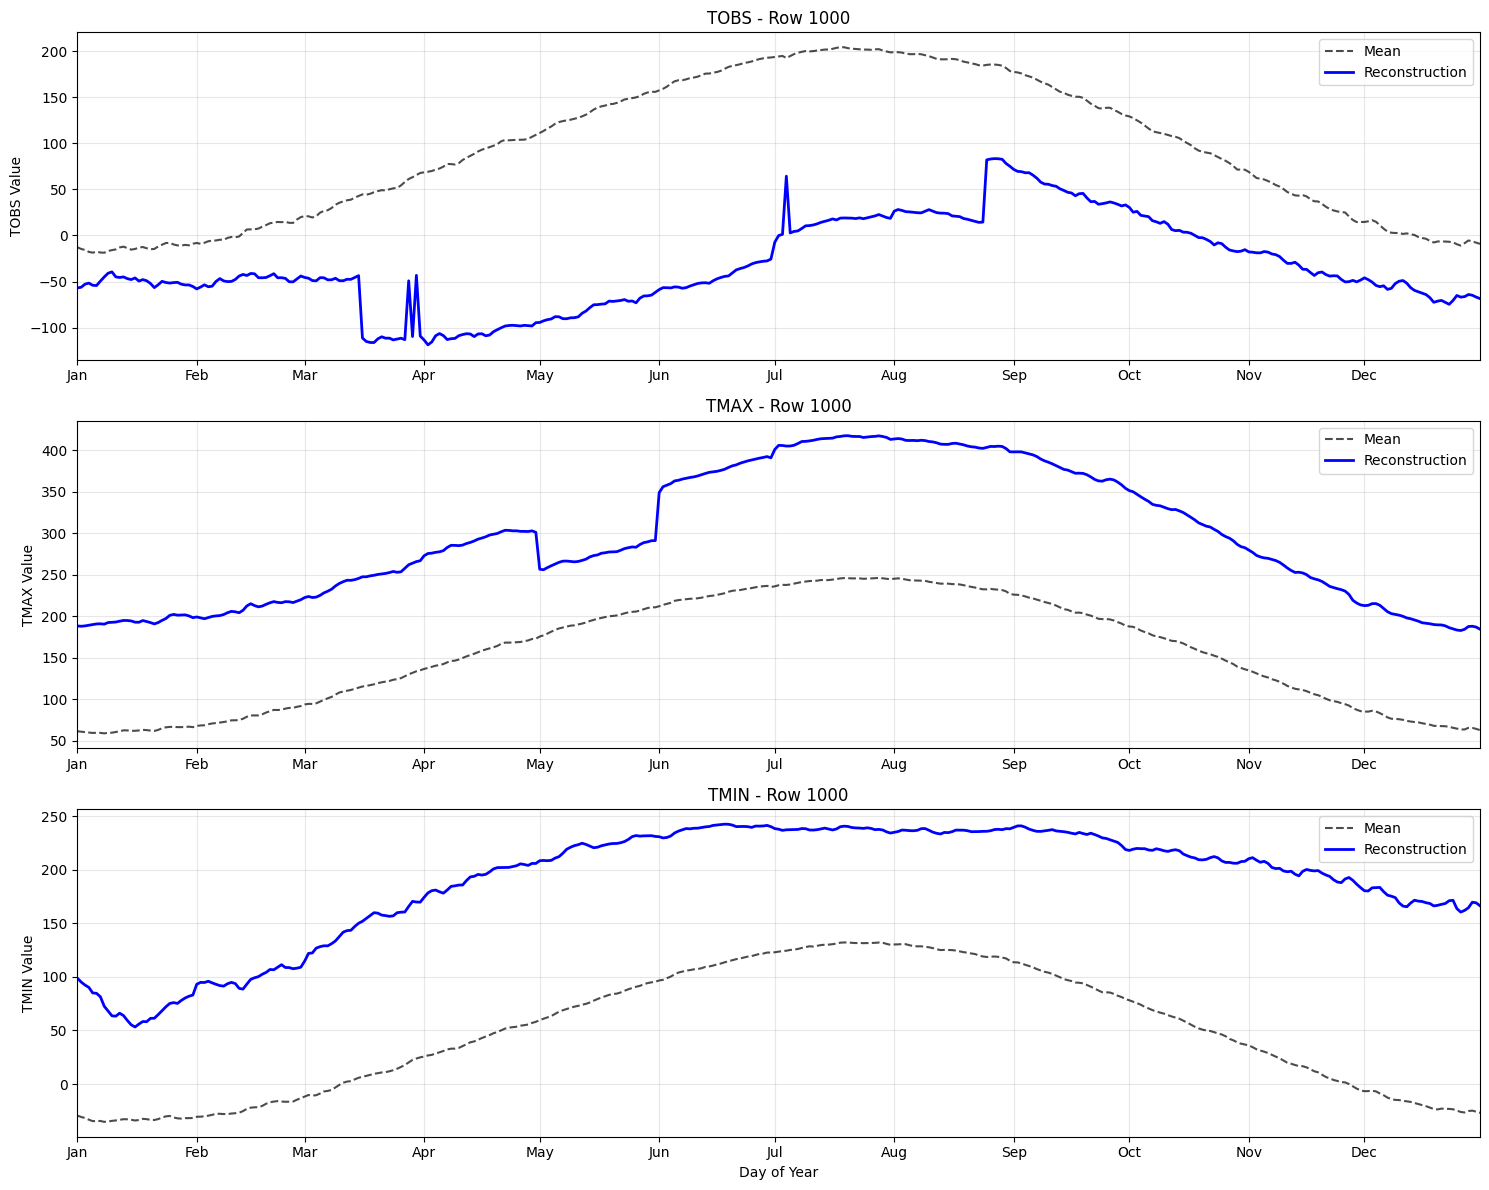

In [11]:
# Example 3: Compare different measurement types
def compare_measurements(row_index, measurement_types):
    """Compare reconstructions for different measurement types."""
    fig, axes = plt.subplots(len(measurement_types), 1, figsize=(15, 4*len(measurement_types)))
    
    if len(measurement_types) == 1:
        axes = [axes]
    
    for i, measurement_type in enumerate(measurement_types):
        if measurement_type not in pca_results:
            continue
            
        # Get row data
        row_data = coefficients_df.iloc[row_index]
        
        # Get PCA data
        pca_data = pca_results[measurement_type]
        mean_values = pca_data['mean']
        components = pca_data['components']
        
        # Get coefficients
        coefficients = [row_data[f'PC{i+1}'] for i in range(10)]
        
        # Reconstruct signal
        reconstructed = reconstruct_signal(mean_values, components, coefficients)
        
        # Plot
        days = np.arange(1, 366)
        axes[i].plot(days, mean_values, 'k--', alpha=0.7, label='Mean')
        axes[i].plot(days, reconstructed, 'b-', linewidth=2, label='Reconstruction')
        axes[i].set_title(f'{measurement_type} - Row {row_index}')
        axes[i].set_ylabel(f'{measurement_type} Value')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
        # Add month labels
        month_boundaries = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366]
        month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
        axes[i].set_xticks(month_boundaries)
        axes[i].set_xticklabels(month_labels)
        axes[i].set_xlim(1, 365)
    
    axes[-1].set_xlabel('Day of Year')
    plt.tight_layout()
    plt.show()

# Compare TOBS, TMAX, TMIN for the same row
compare_measurements(1000, ['TOBS', 'TMAX', 'TMIN'])


## Custom Analysis

You can now:
1. **Change the row index** in the examples above to analyze different stations/years
2. **Change the measurement type** to analyze different weather variables
3. **Adjust max_components** to see how many PCA components are needed for good reconstruction
4. **Use the functions** to create your own custom visualizations

### Available Functions:
- `visualize_reconstruction(row_idx, measurement_type, show_progressive=True, max_components=3)`
- `find_signals_close_to_mean(measurement_type, n_samples=5, years_range=(2000, 2025))`
- `compare_measurements(row_index, measurement_types)`
- `reconstruct_signal(mean_values, components, coefficients, n_components=None)`


In [12]:
# Quick summary of available data
print("=== Data Summary ===")
print(f"Total rows in coefficients: {len(coefficients_df)}")
print(f"Available measurement types: {list(coefficients_df['ELEMENT'].unique())}")
print(f"Available PCA results: {list(pca_results.keys())}")

print("\nRows per measurement type:")
for element in coefficients_df['ELEMENT'].unique():
    count = len(coefficients_df[coefficients_df['ELEMENT'] == element])
    print(f"  {element}: {count:,} rows")

print("\nPCA Components per measurement type:")
for measurement, data in pca_results.items():
    print(f"  {measurement}: {data['components'].shape[0]} components, "
          f"explained variance: {data['explained_variance_ratios'][:3].sum():.3f} (top 3)")


=== Data Summary ===
Total rows in coefficients: 7415065
Available measurement types: ['SNWD', 'PRCP', 'TMIN', 'SNOW', 'TMAX', 'TOBS', 'TAVG']
Available PCA results: ['SNWD', 'PRCP', 'TMIN', 'SNOW', 'TMAX', 'TOBS', 'TAVG']

Rows per measurement type:


  SNWD: 1,015,287 rows


  PRCP: 2,443,678 rows


  TMIN: 1,122,218 rows


  SNOW: 1,012,768 rows


  TMAX: 1,121,369 rows


  TOBS: 403,796 rows


  TAVG: 295,949 rows

PCA Components per measurement type:
  SNWD: 10 components, explained variance: 0.912 (top 3)
  PRCP: 10 components, explained variance: 0.659 (top 3)
  TMIN: 10 components, explained variance: 0.939 (top 3)
  SNOW: 10 components, explained variance: 0.877 (top 3)
  TMAX: 10 components, explained variance: 0.917 (top 3)
  TOBS: 10 components, explained variance: 0.909 (top 3)
  TAVG: 10 components, explained variance: 0.953 (top 3)
